In [1]:
# Import standard libraries

import pandas as pd
import os

# Telling a story

You want to create a figure that answers a _single_ question, for example:

<H4>
    <font color='orange'><b> --> How does the national energy consumption evolve with the change in temperature? </b></font>
</H4>

You should also determine who will be your audience (to the best of your knowledge):

<H4>
    <font color='orange'><b> My audience: A public of non experts </b></font>
</H4>

Now that these two aspects are clearly stated, let's go throuh the process of answering our question with a nice Figure!  
But first we need data!

## Import the data

Download the "Pickles" folder from google drive (*.../Modules/DataViz/DataViz3/Pickles)* and unzip its content in a new folder. There should be a total of 4 pickles in the folder:

In [2]:
path_to_pickles = '../data/Pickles'

os.listdir(path_to_pickles)

['df_temperatures.pkl',
 'df_eolien_norm.pkl',
 'df_solaire_norm.pkl',
 'df_data_nationales.pkl']

Import the relevant pickles into pandas dataframes:

In [3]:
import pandas as pd

directory = path_to_pickles

df_data_nationales = pd.read_pickle(directory + '/df_data_nationales.pkl')
df_temperatures = pd.read_pickle(directory + '/df_temperatures.pkl')
# df_solaire = pd.read_pickle(directory + '/df_solaire_norm.pkl')
# df_eolien = pd.read_pickle(directory + '/df_eolien_norm.pkl')

In [4]:
df_data_nationales.head()

,Consommation,Fioul,Charbon,Gaz,Nucléaire,Eolien,Solaire,Hydraulique,Pompage,Bioénergies,Ech. physiques
DateTime,,,,,,,,,,,
2012-01-01 00:00:00,58315.0,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,-1139.0,719.0,-9806.0
2012-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:30:00,58315.0,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,-1139.0,719.0,-9806.0
2012-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,56231.0,492.0,25.0,3834.0,51747.0,3536.0,0.0,7598.0,-1730.0,721.0,-9993.0


In [28]:
df_temperatures.head()
df_temperatures.columns


Index(['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Grand-Est', 'Hauts-de-France', 'Ile-de-France',
       'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'PACA',
       'Pays-de-la-Loire'],
      dtype='object', name='Region')

Check missing values with missingno package

<Axes: >

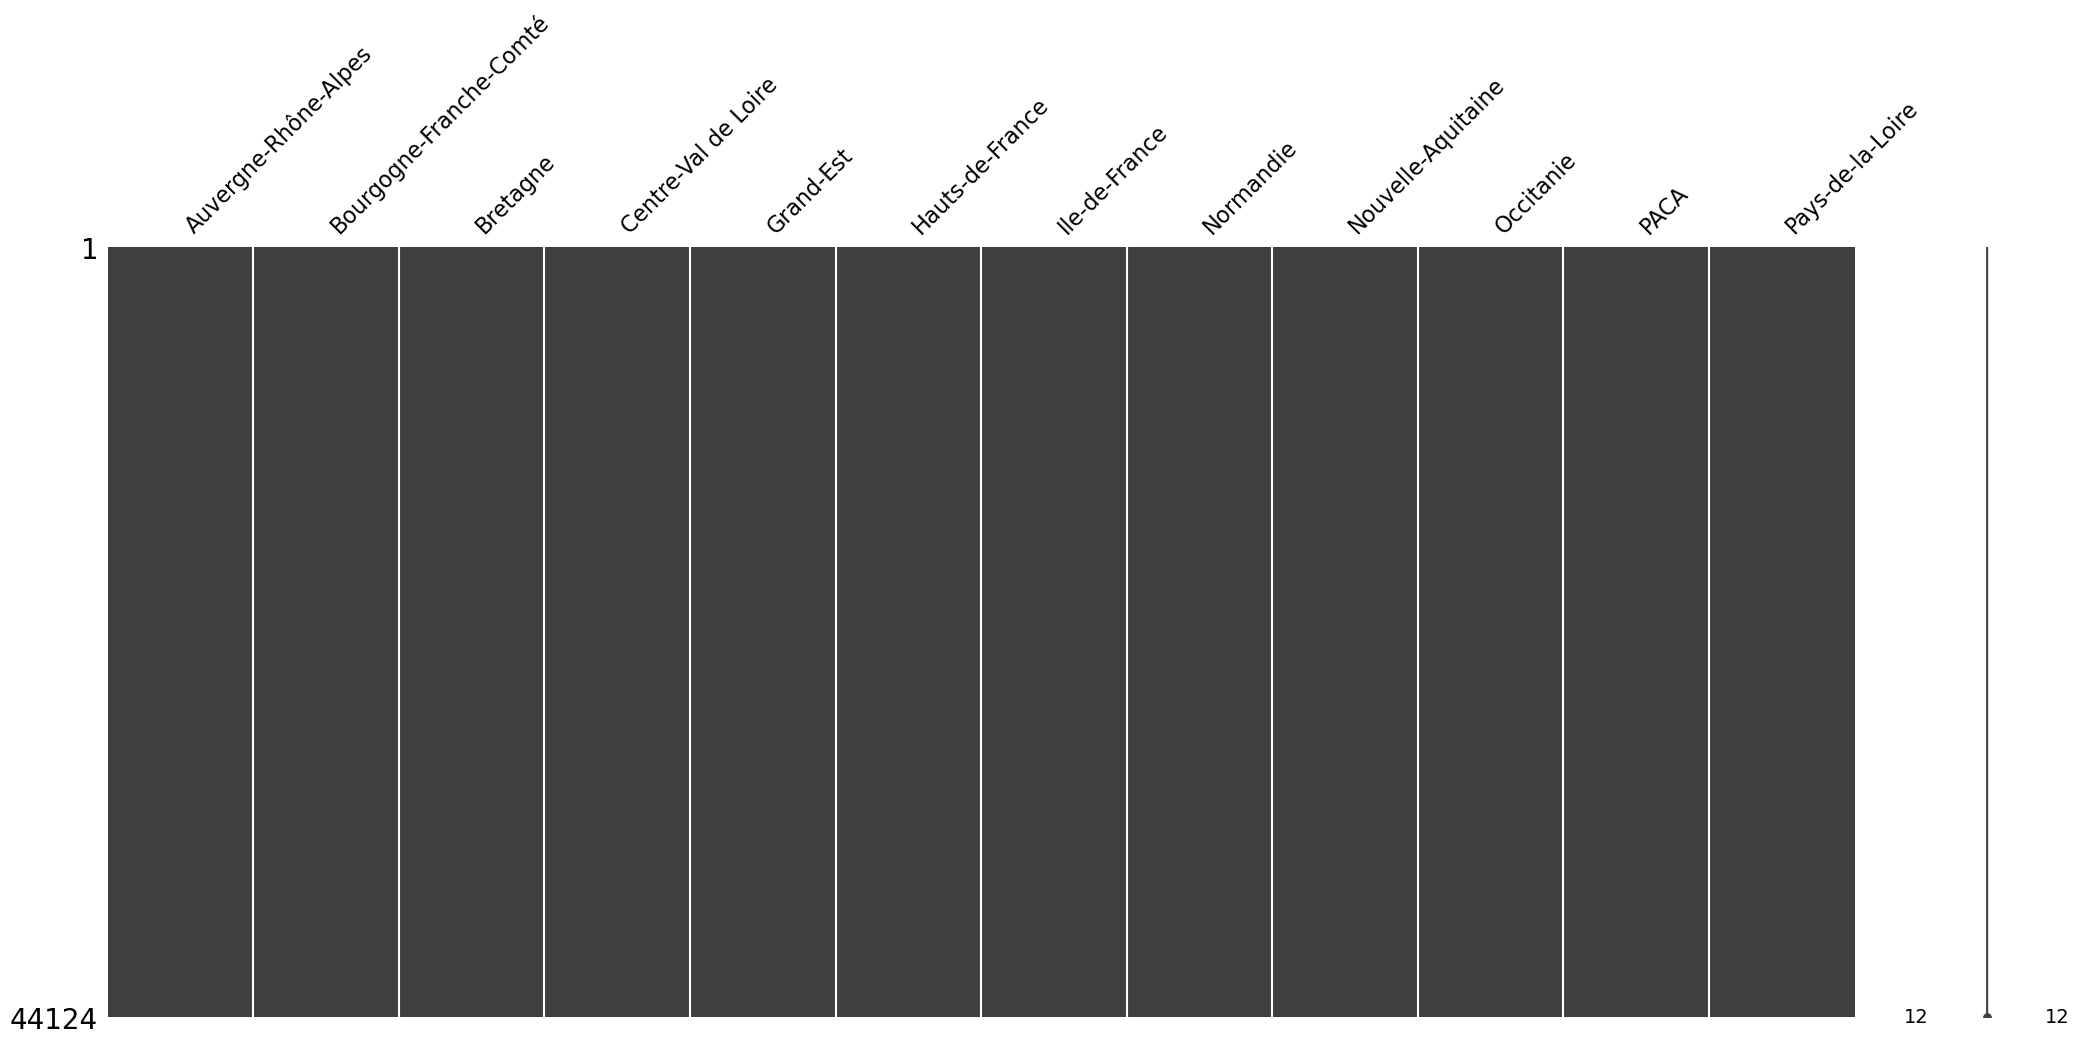

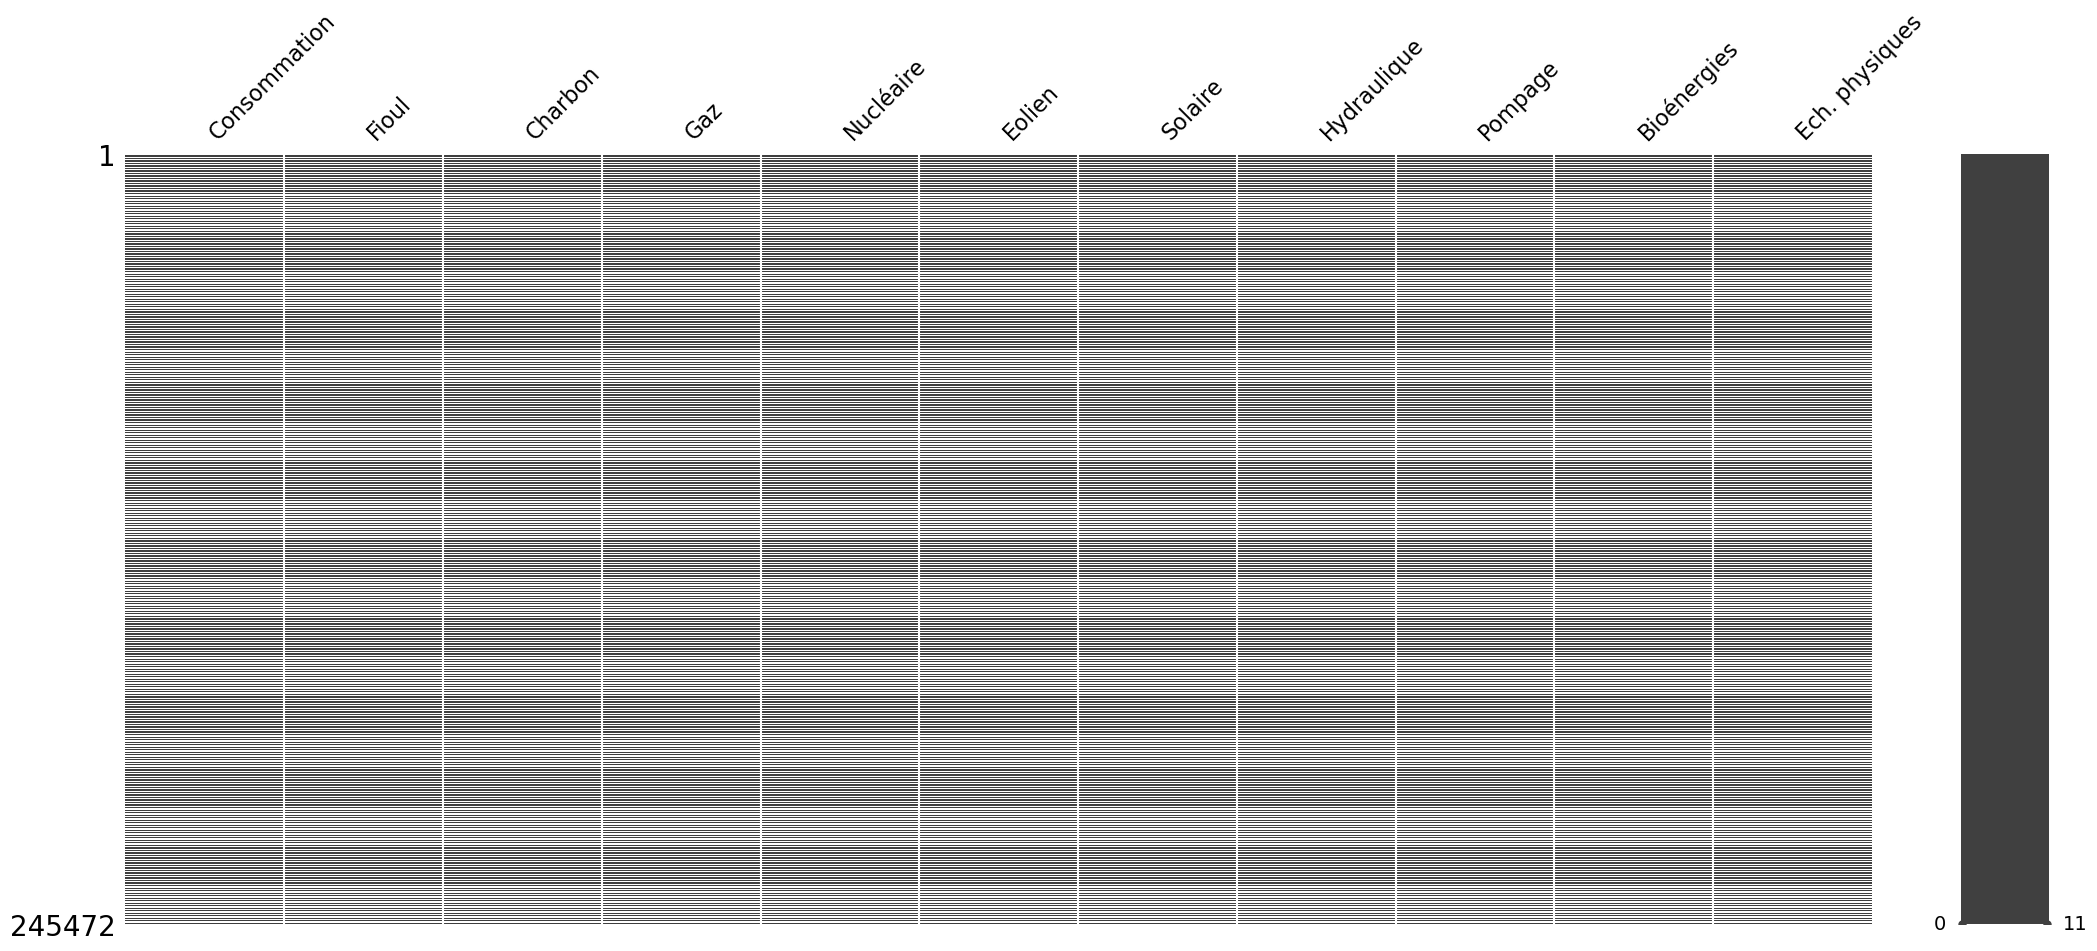

In [6]:
import missingno as msno #install with pip/conda if necessary

msno.matrix(df_temperatures)
msno.matrix(df_data_nationales)

### Prepare the data

1. Retreive the information about the evolution of the national energy consumption in France. Keep only the column "Consommation" and downsample to hourly data (instead of every 15 min):

In [7]:
conso_nat = pd.DataFrame(df_data_nationales['Consommation'].dropna(axis=0).resample('H').mean())
conso_nat.head()

/tmp/ipykernel_33584/2816914598.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  conso_nat = pd.DataFrame(df_data_nationales['Consommation'].dropna(axis=0).resample('H').mean())


,Consommation
DateTime,
2012-01-01 00:00:00,58315.0
2012-01-01 01:00:00,56153.0
2012-01-01 02:00:00,55221.5
2012-01-01 03:00:00,51580.0
2012-01-01 04:00:00,48378.5


2. Retreive the information about the evolution of the average temperature in France. Average out the temperature over the different regions and resample to hourly data:

In [8]:
avg_temp_nat = pd.DataFrame(df_temperatures.mean(axis=1).dropna(axis=0).resample('H').mean(), columns=['avg_temperature'])
avg_temp_nat.head()

/tmp/ipykernel_33584/3244151950.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  avg_temp_nat = pd.DataFrame(df_temperatures.mean(axis=1).dropna(axis=0).resample('H').mean(), columns=['avg_temperature'])


,avg_temperature
date_validite,
2013-01-01 23:00:00,4.900278
2013-01-02 00:00:00,4.690972
2013-01-02 01:00:00,4.550000
2013-01-02 02:00:00,4.433750
2013-01-02 03:00:00,4.305000


3. Merge the two dataframes together

Merging our two dataframes makes it easier to handle and save our data. the 'df.merge()' method also ensures each column has the same length (which makes plotting our data suddenly very simple).

In [9]:
merged = conso_nat.merge(avg_temp_nat, how='inner', left_index=True, right_index=True)
merged.head()

,Consommation,avg_temperature
2013-01-01 23:00:00,60870.0,4.900278
2013-01-02 00:00:00,59298.0,4.690972
2013-01-02 01:00:00,56016.5,4.550000
2013-01-02 02:00:00,55624.0,4.433750
2013-01-02 03:00:00,53148.0,4.305000


4. Resample the pandas dataframe to daily data points

In [10]:
merged_D = merged.resample('D').mean()

5. Normalize our data (we're trying to show a trend, it is therefore not necesary to use the absolute values)

In [11]:
merged_D_Norm = merged_D.apply(lambda x: (x - x.min())/(x.max() - x.min())).copy()

6. create two new columns where the data is smoothed out (using a rolling mean). These will be used as trendline in the plot. Clean the data if necessary. Save the resulting dataframe 

In [12]:
rolling_window = 100
merged_D_Norm['smothed_conso'] = merged_D_Norm.Consommation.rolling(rolling_window, center=True).mean()
merged_D_Norm['smothed_avg_temp'] = merged_D_Norm.avg_temperature.rolling(rolling_window, center=True).mean()
merged_D_Norm.head(100)

,Consommation,avg_temperature,smothed_conso,smothed_avg_temp
2013-01-01,0.495455,0.274930,NaN,NaN
2013-01-02,0.566631,0.305012,NaN,NaN
2013-01-03,0.608752,0.352956,NaN,NaN
2013-01-04,0.581250,0.388275,NaN,NaN
2013-01-05,0.481383,0.369614,NaN,NaN
...,...,...,...,...
2013-04-06,0.539613,0.302002,0.475429,0.394832
2013-04-07,0.443637,0.322616,0.470289,0.396582
2013-04-08,0.561287,0.357568,0.467329,0.399396
2013-04-09,0.557781,0.403549,0.465066,0.401982


In [13]:
merged_D_Norm.dropna(inplace=True)

7. write the dataframe to a folder data_processed in notebook_guide

In [14]:
ROOT = '.'
folder = 'data_processed'
fp = os.path.join(ROOT, folder) # fp is folderpath

if not os.path.exists(fp):
    os.mkdir(fp)

filename = "consumption_vs_temperature.pkl"
fpath_data = os.path.join(fp, filename)
merged_D_Norm.to_pickle(fpath_data)

8. Make a standard plot of the dataframe

<Axes: >

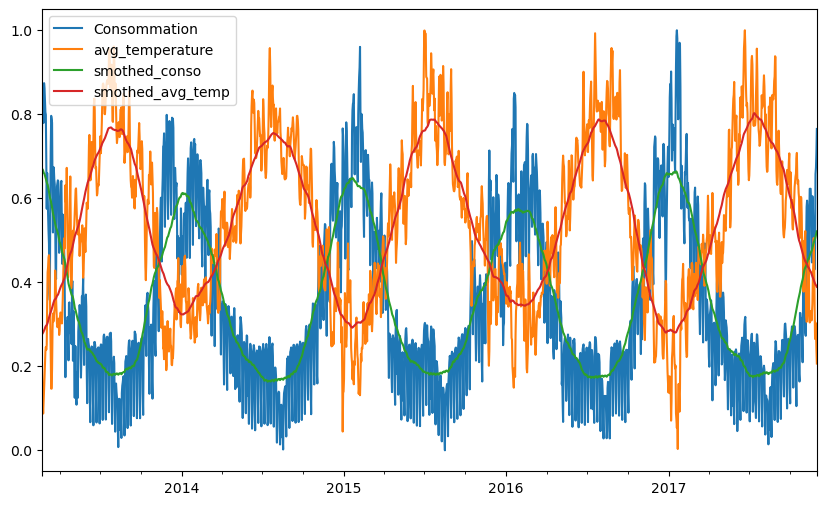

In [15]:
merged_D_Norm.plot(figsize=(10,6))

... hum, well... that looks... ... lets use to plotly to make this figure look nice and add some interactivity!

# Plotting with plotly

## Setup before plotting

Create a font dictionnary that will help you styling your figures

In [16]:
# example

font = {
    'family': "Courier New",
    'size': {
        'small': 12,
        'medium': 16,
        'big': 20
        },
    'color': {
        'axes': 'rgb(180, 180, 180)',
        'primary': 'lightcoral',
        'secondary': 'lightsteelblue',
        'highlight': 'sandybrown'
    },
    'line width': 2
}

Note: There are a lot of named CSS colors you can pick from to customize your graph, but rememebr: don't pick too many! Three different colors is usually more than enough.  
FYI, these are the colors, play around with them (also check out https://developer.mozilla.org/en-US/docs/Web/CSS/named-color to visualise the colors):

*aliceblue, antiquewhite, aqua, aquamarine, azure,
beige, bisque, black, blanchedalmond, blue,
blueviolet, brown, burlywood, cadetblue,
chartreuse, chocolate, coral, cornflowerblue,
cornsilk, crimson, cyan, darkblue, darkcyan,
darkgoldenrod, darkgray, darkgrey, darkgreen,
darkkhaki, darkmagenta, darkolivegreen, darkorange,
darkorchid, darkred, darksalmon, darkseagreen,
darkslateblue, darkslategray, darkslategrey,
darkturquoise, darkviolet, deeppink, deepskyblue,
dimgray, dimgrey, dodgerblue, firebrick,
floralwhite, forestgreen, fuchsia, gainsboro,
ghostwhite, gold, goldenrod, gray, grey, green,
greenyellow, honeydew, hotpink, indianred, indigo,
ivory, khaki, lavender, lavenderblush, lawngreen,
lemonchiffon, lightblue, lightcoral, lightcyan,
lightgoldenrodyellow, lightgray, lightgrey,
lightgreen, lightpink, lightsalmon, lightseagreen,
lightskyblue, lightslategray, lightslategrey,
lightsteelblue, lightyellow, lime, limegreen,
linen, magenta, maroon, mediumaquamarine,
mediumblue, mediumorchid, mediumpurple,
mediumseagreen, mediumslateblue, mediumspringgreen,
mediumturquoise, mediumvioletred, midnightblue,
mintcream, mistyrose, moccasin, navajowhite, navy,
oldlace, olive, olivedrab, orange, orangered,
orchid, palegoldenrod, palegreen, paleturquoise,
palevioletred, papayawhip, peachpuff, peru, pink,
plum, powderblue, purple, red, rosybrown,
royalblue, rebeccapurple, saddlebrown, salmon,
sandybrown, seagreen, seashell, sienna, silver,
skyblue, slateblue, slategray, slategrey, snow,
springgreen, steelblue, tan, teal, thistle, tomato,
turquoise, violet, wheat, white, whitesmoke,
yellow, yellowgreen*

Once you settled on your styles, you can export this "style dictionnary" (for example as **style.json**) so it can be reused elsewhere in your project (or even in different projects). This will help you ensure style consistency throughout your plotting projects.

1. Write the font dictionnary to a json file in a css folder in notebook_guide

In [17]:
import json

ROOT = '.'
path_css = os.path.join(ROOT, 'static')

if not os.path.exists(path_css):
    os.mkdir(path_css)

filename = "style.json"
fpath_styling = os.path.join(path_css, filename)

with open(fpath_styling, 'w') as file:
    file.write(json.dumps(font, indent=4, sort_keys=True))

2. Create a simple function that adds lineplots to a figure (in plotly these are called "traces"). The purpose of this function is to allow you to easily add extra 'traces' (for example lines) to your figure

In [18]:
def add_data_to_figure(fig, x, y, label="no label", color="red", line_width=1, opacity=1):
    
    fig.add_trace(
        go.Scatter(
            x=x, y=y, 
            mode='lines+markers', # try only lines and you'll see that lasso and box select dissapear when there are too many datapoints
            name=label,
            line=dict(color=color, width=line_width),
            connectgaps=True,
            opacity=opacity
    ))

    return fig

## Creating the actual figure

1. Load the font dict

In [19]:
with open(fpath_styling, 'r') as file:
    font = json.load(file)
    print(json.dumps(font, indent=4,))

{
    "color": {
        "axes": "rgb(180, 180, 180)",
        "highlight": "sandybrown",
        "primary": "lightcoral",
        "secondary": "lightsteelblue"
    },
    "family": "Courier New",
    "line width": 2,
    "size": {
        "big": 20,
        "medium": 16,
        "small": 12
    }
}


2. Load the pre-processed data

In [20]:
df = pd.read_pickle(fpath_data)
df.head()

,Consommation,avg_temperature,smothed_conso,smothed_avg_temp
2013-02-20,0.730699,0.232575,0.669662,0.274972
2013-02-21,0.808156,0.152652,0.669465,0.277269
2013-02-22,0.851028,0.108949,0.668258,0.279018
2013-02-23,0.834425,0.087439,0.665326,0.280464
2013-02-24,0.779587,0.114377,0.661254,0.282891


3. Choose the data you want to plot and _how_ you want to plot it

In [21]:
x = df.index

# trace 1: average temperature
y1 = df.avg_temperature
label = 'Average temperature'
color = font['color']['primary']
lw = font['line width']
opacity = 0.2
plot_args1 = (x, y1, label, color, lw, opacity)

# trace 2: energy consumption
y2 = df.Consommation
label = 'Energy consumption'
color = font['color']['secondary']
lw = font['line width']
opacity = 0.2
plot_args2 = (x, y2, label, color, lw, opacity)

4. Create a new figure and add the traces to it

In [22]:
import plotly.graph_objects as go

fig = go.FigureWidget()

add_data_to_figure(fig, *plot_args1)
add_data_to_figure(fig, *plot_args2)

fig.show()

...hum ... well, at least it's interactive now!

Let's add even more traces:

In [23]:
# trace 3: average temperature - smoothed
y3 = df.smothed_avg_temp
label = 'temp - smoothed'
color = font['color']['primary']
lw = font['line width'] + 0.5
plot_args3 = (x, y3, label, color, lw)

# trace 4: energy consumption - smoothed
y4 = df.smothed_conso
label = "conso - smoothed"
color = font['color']['secondary']
lw = font['line width'] + 0.5
plot_args4 = (x, y4, label, color, lw)


add_data_to_figure(fig, *plot_args3)
add_data_to_figure(fig, *plot_args4)


fig.show()

After having dialed back the "raw data" it already looks a lot less crowded. Again, we're just interested in the general trends here.

Now we'll add some annotations to the figure:

https://plotly.com/python/text-and-annotations/

Let's check the default font sizes that we've set earlier:

In [24]:
font['size']

{'big': 20, 'medium': 16, 'small': 12}

In [25]:
text = {
    'title': "When the temperature drops, the energy consumption rises.",
    'source': "RTE france (normalised data)"
}


annotations = []

# add a title (used to describe the figure)
annotations.append(dict(xref='paper', yref='paper',
                        x=0.5, y=1.10,
                        xanchor='center', yanchor='bottom',
                        text=text["title"],
                        font=dict(family=font["family"],
                                  size=font["size"]["big"],
                                  color=font["color"]['axes']),
                        showarrow=False))


# add text at the bottom of the figure
annotations.append(dict(xref='paper', yref='paper',
                        x=0.5, y=-0.2,
                        xanchor='center', yanchor='top',
                        text=text["source"],
                        font=dict(family=font["family"],
                                  size=font["size"]["small"],
                                  color=font["color"]['axes']),
                        showarrow=False))


fig.update_layout(annotations=annotations)

FigureWidget({
    'data': [{'connectgaps': True,
              'line': {'color': 'lightcoral', 'width': 2},
              'mode': 'lines+markers',
              'name': 'Average temperature',
              'opacity': 0.2,
              'type': 'scatter',
              'uid': 'b7e62e3d-0a87-4f98-aa42-a6c59d97604d',
              'x': array([datetime.datetime(2013, 2, 20, 0, 0),
                          datetime.datetime(2013, 2, 21, 0, 0),
                          datetime.datetime(2013, 2, 22, 0, 0), ...,
                          datetime.datetime(2017, 11, 28, 0, 0),
                          datetime.datetime(2017, 11, 29, 0, 0),
                          datetime.datetime(2017, 11, 30, 0, 0)], dtype=object),
              'y': array([0.23257525, 0.15265236, 0.10894913, ..., 0.29147852, 0.24040629,
                          0.20648391])},
             {'connectgaps': True,
              'line': {'color': 'lightsteelblue', 'width': 2},
              'mode': 'lines+markers',
      

What do we want?! **MORE ANNOTATIONS !!**  
Wen do we want them?! **NOOOOOW !!!**

In [26]:
# Adding labels to the traces (directly on the plot)
x, y, label, color, _ = plot_args3
annotations.append(dict(xref='x', yref='y',
                        x=x[-1] + pd.offsets.Day(20),
                        y=y.iloc[-1],
                        xanchor='left', yanchor='middle',
                        text="Average Temperature",
                        font=dict(family=font["family"],
                                  size=font["size"]["medium"],
                                  color=color),
                        showarrow=False))


x, y, label, color, _ = plot_args4
annotations.append(dict(xref='x', yref='y',
                        x=x[-1] + pd.offsets.Day(20),
                        y=y.iloc[-1],
                        xanchor='left', yanchor='middle',
                        text="Energy consumption",                        
                        font=dict(family=font["family"],
                                  size=font["size"]["medium"],
                                  color=color),
                        showarrow=False))


fig.update_layout(annotations=annotations)

FigureWidget({
    'data': [{'connectgaps': True,
              'line': {'color': 'lightcoral', 'width': 2},
              'mode': 'lines+markers',
              'name': 'Average temperature',
              'opacity': 0.2,
              'type': 'scatter',
              'uid': 'b7e62e3d-0a87-4f98-aa42-a6c59d97604d',
              'x': array([datetime.datetime(2013, 2, 20, 0, 0),
                          datetime.datetime(2013, 2, 21, 0, 0),
                          datetime.datetime(2013, 2, 22, 0, 0), ...,
                          datetime.datetime(2017, 11, 28, 0, 0),
                          datetime.datetime(2017, 11, 29, 0, 0),
                          datetime.datetime(2017, 11, 30, 0, 0)], dtype=object),
              'y': array([0.23257525, 0.15265236, 0.10894913, ..., 0.29147852, 0.24040629,
                          0.20648391])},
             {'connectgaps': True,
              'line': {'color': 'lightsteelblue', 'width': 2},
              'mode': 'lines+markers',
      

Now make the figure beautiful _(this can take a lot of time, but once it's done it's done!)_:

In [27]:
import datetime

fig.update_layout(
    
    # customize x-axis
    xaxis_range=[datetime.datetime(2013, 1, 1),
                 datetime.datetime(2019, 1, 1)],
    xaxis=dict(
        type="date",
        tick0="2013-01-01", # first tick
        dtick="M12", # interval between each tick following 'tick0' (1 year, ie 12 months)
        tickformat="| %Y |",
        tickvals=list(range(2013, 2019)),
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor=font["color"]['axes'],
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family=font["family"] + " Bold",
            size=font["size"]["medium"],
            color=font["color"]['highlight'],
        ),
    ),
    
    # customize x and y-axis
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=False,
    ),
    
    # figure size
    autosize=False,
    width=1500,
    height=500,
    
    margin=dict(
        autoexpand=True,
        l=0,
        r=110,
        t=110,
        b=110,
        
    ),

    
    # disable the legend
    showlegend=False,
    
    # change the backgroud color
    plot_bgcolor='white'
)

FigureWidget({
    'data': [{'connectgaps': True,
              'line': {'color': 'lightcoral', 'width': 2},
              'mode': 'lines+markers',
              'name': 'Average temperature',
              'opacity': 0.2,
              'type': 'scatter',
              'uid': 'b7e62e3d-0a87-4f98-aa42-a6c59d97604d',
              'x': array([datetime.datetime(2013, 2, 20, 0, 0),
                          datetime.datetime(2013, 2, 21, 0, 0),
                          datetime.datetime(2013, 2, 22, 0, 0), ...,
                          datetime.datetime(2017, 11, 28, 0, 0),
                          datetime.datetime(2017, 11, 29, 0, 0),
                          datetime.datetime(2017, 11, 30, 0, 0)], dtype=object),
              'y': array([0.23257525, 0.15265236, 0.10894913, ..., 0.29147852, 0.24040629,
                          0.20648391])},
             {'connectgaps': True,
              'line': {'color': 'lightsteelblue', 'width': 2},
              'mode': 'lines+markers',
      